In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2025-01-11 20:05:16--  https://pjreddie.com/media/files/mnist_train.csv
Resolvendo pjreddie.com (pjreddie.com)... 162.0.215.52
Conectando-se a pjreddie.com (pjreddie.com)|162.0.215.52|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 109575994 (104M) [text/csv]
Salvando em: ‘data/mnist_train.csv.1’

mnist_train.csv.1   100%[===================>] 104,50M  17,7MB/s    em 7,2s    

2025-01-11 20:05:24 (14,4 MB/s) - ‘data/mnist_train.csv.1’ salvo [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [7]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [8]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

  0%|          | 0/16 [00:00<?, ?it/s]/home/daniel/Documentos/dados/projetos/16 - Topicos Contemporaneos/topicos_contemporaneos/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 16/16 [00:00<00:00, 18.90it/s]


Epoch 1, Train Loss: 2.310, Train Accuracy: 14.30%
Epoch 1, Val Loss: 2.222, Val Accuracy: 22.80%


100%|██████████| 16/16 [00:00<00:00, 54.13it/s]


Epoch 2, Train Loss: 2.071, Train Accuracy: 30.60%
Epoch 2, Val Loss: 1.818, Val Accuracy: 45.00%


100%|██████████| 16/16 [00:00<00:00, 88.17it/s]


Epoch 3, Train Loss: 1.490, Train Accuracy: 53.60%
Epoch 3, Val Loss: 1.041, Val Accuracy: 65.20%


100%|██████████| 16/16 [00:00<00:00, 80.05it/s]


Epoch 4, Train Loss: 0.848, Train Accuracy: 72.40%
Epoch 4, Val Loss: 0.627, Val Accuracy: 78.00%


100%|██████████| 16/16 [00:00<00:00, 59.30it/s]


Epoch 5, Train Loss: 0.551, Train Accuracy: 80.80%
Epoch 5, Val Loss: 0.543, Val Accuracy: 81.20%
Treinamento concluído


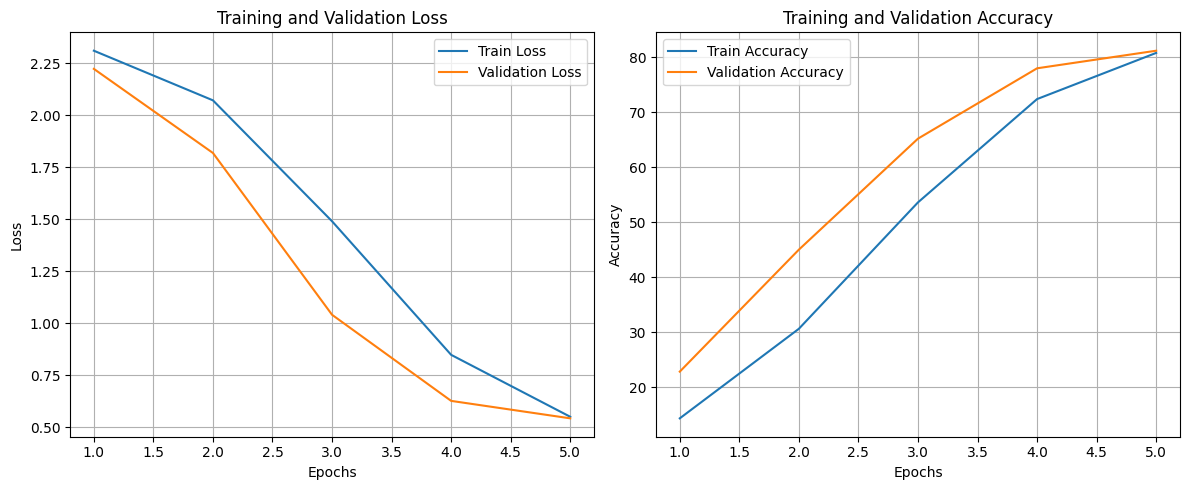

In [11]:
epochs = range(1, len(history['train_losses']) + 1)
    
# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
test_model(model, testloader)

Acurácia da rede na base de teste: 84.20%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [18]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, filters_1=6, filters_2=8, num_neurons=64):
        super(CNN, self).__init__()
        self.filters_2 = filters_2
        self.conv1 = nn.Conv2d(1, filters_1, 5)
        self.conv2 = nn.Conv2d(filters_1, filters_2, 5)
        self.fc1 = nn.Linear(filters_2 * 4 * 4, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [17]:
parameters = [
    (6, 12),
    (6, 16),
    (8, 12),
    (6, 16),
]

for filter_1, filter_2 in parameters:
    print(f'teste com filtro 1={filter_1} e filtro 2={filter_2}')

    model = CNN(filters_1=filter_1, filters_2=filter_2)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    test_model(model, testloader)
    print()

teste com filtro 1=6 e filtro 2=12


100%|██████████| 16/16 [00:00<00:00, 66.88it/s]


Epoch 1, Train Loss: 2.308, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.212, Val Accuracy: 27.60%


100%|██████████| 16/16 [00:00<00:00, 81.57it/s]


Epoch 2, Train Loss: 2.026, Train Accuracy: 31.60%
Epoch 2, Val Loss: 1.731, Val Accuracy: 45.20%


100%|██████████| 16/16 [00:00<00:00, 56.24it/s]


Epoch 3, Train Loss: 1.376, Train Accuracy: 54.20%
Epoch 3, Val Loss: 0.882, Val Accuracy: 73.60%


100%|██████████| 16/16 [00:00<00:00, 72.81it/s]


Epoch 4, Train Loss: 0.878, Train Accuracy: 71.40%
Epoch 4, Val Loss: 0.697, Val Accuracy: 78.80%


100%|██████████| 16/16 [00:00<00:00, 85.76it/s]


Epoch 5, Train Loss: 0.686, Train Accuracy: 77.20%
Epoch 5, Val Loss: 0.488, Val Accuracy: 85.00%
Treinamento concluído
Acurácia da rede na base de teste: 87.80%

teste com filtro 1=6 e filtro 2=16


100%|██████████| 16/16 [00:00<00:00, 86.23it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 19.40%
Epoch 1, Val Loss: 2.136, Val Accuracy: 34.20%


100%|██████████| 16/16 [00:00<00:00, 80.74it/s]


Epoch 2, Train Loss: 1.851, Train Accuracy: 40.40%
Epoch 2, Val Loss: 1.388, Val Accuracy: 57.80%


100%|██████████| 16/16 [00:00<00:00, 54.26it/s]


Epoch 3, Train Loss: 1.137, Train Accuracy: 62.10%
Epoch 3, Val Loss: 0.751, Val Accuracy: 75.80%


100%|██████████| 16/16 [00:00<00:00, 51.45it/s]


Epoch 4, Train Loss: 0.725, Train Accuracy: 75.80%
Epoch 4, Val Loss: 0.580, Val Accuracy: 81.80%


100%|██████████| 16/16 [00:00<00:00, 52.89it/s]


Epoch 5, Train Loss: 0.520, Train Accuracy: 84.20%
Epoch 5, Val Loss: 0.401, Val Accuracy: 88.20%
Treinamento concluído
Acurácia da rede na base de teste: 90.20%

teste com filtro 1=8 e filtro 2=12


100%|██████████| 16/16 [00:00<00:00, 86.42it/s]


Epoch 1, Train Loss: 2.297, Train Accuracy: 13.60%
Epoch 1, Val Loss: 2.202, Val Accuracy: 24.40%


100%|██████████| 16/16 [00:00<00:00, 87.27it/s]


Epoch 2, Train Loss: 2.064, Train Accuracy: 28.60%
Epoch 2, Val Loss: 1.759, Val Accuracy: 50.00%


100%|██████████| 16/16 [00:00<00:00, 71.94it/s]


Epoch 3, Train Loss: 1.395, Train Accuracy: 55.20%
Epoch 3, Val Loss: 0.849, Val Accuracy: 73.60%


100%|██████████| 16/16 [00:00<00:00, 60.81it/s]


Epoch 4, Train Loss: 0.813, Train Accuracy: 72.50%
Epoch 4, Val Loss: 0.565, Val Accuracy: 81.00%


100%|██████████| 16/16 [00:00<00:00, 59.30it/s]


Epoch 5, Train Loss: 0.562, Train Accuracy: 82.00%
Epoch 5, Val Loss: 0.449, Val Accuracy: 86.00%
Treinamento concluído
Acurácia da rede na base de teste: 88.60%

teste com filtro 1=6 e filtro 2=16


100%|██████████| 16/16 [00:00<00:00, 85.89it/s]

Epoch 1, Train Loss: 2.290, Train Accuracy: 17.20%


Epoch 1, Val Loss: 2.190, Val Accuracy: 28.20%


100%|██████████| 16/16 [00:00<00:00, 62.75it/s]


Epoch 2, Train Loss: 2.042, Train Accuracy: 33.70%
Epoch 2, Val Loss: 1.708, Val Accuracy: 54.20%


100%|██████████| 16/16 [00:00<00:00, 60.20it/s]


Epoch 3, Train Loss: 1.371, Train Accuracy: 54.80%
Epoch 3, Val Loss: 0.851, Val Accuracy: 74.40%


100%|██████████| 16/16 [00:00<00:00, 50.43it/s]


Epoch 4, Train Loss: 0.762, Train Accuracy: 74.80%
Epoch 4, Val Loss: 0.520, Val Accuracy: 83.20%


100%|██████████| 16/16 [00:00<00:00, 65.91it/s]


Epoch 5, Train Loss: 0.483, Train Accuracy: 83.10%
Epoch 5, Val Loss: 0.419, Val Accuracy: 87.60%
Treinamento concluído
Acurácia da rede na base de teste: 89.40%



### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [19]:
for i in range(5):
    num_neurons = np.random.randint(10, 100)
    model = CNN(num_neurons=num_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    history = train_model(model, trainloader, valloader, criterion, optimizer)

    print(f'Número de neurônios na camada fully connected: {num_neurons}')
    test_model(model, testloader)
    print()

100%|██████████| 16/16 [00:00<00:00, 72.06it/s]


Epoch 1, Train Loss: 2.272, Train Accuracy: 14.20%
Epoch 1, Val Loss: 2.220, Val Accuracy: 21.40%


100%|██████████| 16/16 [00:00<00:00, 76.71it/s]


Epoch 2, Train Loss: 2.090, Train Accuracy: 31.30%
Epoch 2, Val Loss: 1.889, Val Accuracy: 47.80%


100%|██████████| 16/16 [00:00<00:00, 82.55it/s]


Epoch 3, Train Loss: 1.572, Train Accuracy: 47.70%
Epoch 3, Val Loss: 1.002, Val Accuracy: 71.80%


100%|██████████| 16/16 [00:00<00:00, 78.04it/s]


Epoch 4, Train Loss: 0.977, Train Accuracy: 68.20%
Epoch 4, Val Loss: 0.636, Val Accuracy: 79.60%


100%|██████████| 16/16 [00:00<00:00, 61.07it/s]


Epoch 5, Train Loss: 0.652, Train Accuracy: 78.60%
Epoch 5, Val Loss: 0.486, Val Accuracy: 85.00%
Treinamento concluído
Número de neurônios na camada fully connected: 55
Acurácia da rede na base de teste: 84.00%



100%|██████████| 16/16 [00:00<00:00, 71.28it/s]


Epoch 1, Train Loss: 2.242, Train Accuracy: 18.50%
Epoch 1, Val Loss: 2.167, Val Accuracy: 30.00%


100%|██████████| 16/16 [00:00<00:00, 77.16it/s]


Epoch 2, Train Loss: 1.891, Train Accuracy: 38.30%
Epoch 2, Val Loss: 1.374, Val Accuracy: 66.00%


100%|██████████| 16/16 [00:00<00:00, 81.39it/s]


Epoch 3, Train Loss: 1.099, Train Accuracy: 64.00%
Epoch 3, Val Loss: 0.737, Val Accuracy: 78.80%


100%|██████████| 16/16 [00:00<00:00, 79.71it/s]


Epoch 4, Train Loss: 0.651, Train Accuracy: 79.90%
Epoch 4, Val Loss: 0.534, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:00<00:00, 57.41it/s]


Epoch 5, Train Loss: 0.461, Train Accuracy: 84.20%
Epoch 5, Val Loss: 0.438, Val Accuracy: 86.80%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 89.60%



100%|██████████| 16/16 [00:00<00:00, 83.21it/s]


Epoch 1, Train Loss: 2.235, Train Accuracy: 16.50%
Epoch 1, Val Loss: 2.083, Val Accuracy: 36.40%


100%|██████████| 16/16 [00:00<00:00, 84.87it/s]


Epoch 2, Train Loss: 1.855, Train Accuracy: 38.00%
Epoch 2, Val Loss: 1.279, Val Accuracy: 70.00%


100%|██████████| 16/16 [00:00<00:00, 51.05it/s]


Epoch 3, Train Loss: 1.023, Train Accuracy: 67.40%
Epoch 3, Val Loss: 0.666, Val Accuracy: 78.40%


100%|██████████| 16/16 [00:00<00:00, 65.93it/s]


Epoch 4, Train Loss: 0.594, Train Accuracy: 80.70%
Epoch 4, Val Loss: 0.495, Val Accuracy: 83.20%


100%|██████████| 16/16 [00:00<00:00, 53.68it/s]


Epoch 5, Train Loss: 0.390, Train Accuracy: 87.40%
Epoch 5, Val Loss: 0.400, Val Accuracy: 87.80%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 88.20%



100%|██████████| 16/16 [00:00<00:00, 61.08it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 17.70%
Epoch 1, Val Loss: 2.143, Val Accuracy: 35.60%


100%|██████████| 16/16 [00:00<00:00, 83.35it/s]


Epoch 2, Train Loss: 1.902, Train Accuracy: 41.20%
Epoch 2, Val Loss: 1.495, Val Accuracy: 54.00%


100%|██████████| 16/16 [00:00<00:00, 68.21it/s]


Epoch 3, Train Loss: 1.219, Train Accuracy: 59.10%
Epoch 3, Val Loss: 0.795, Val Accuracy: 73.20%


100%|██████████| 16/16 [00:00<00:00, 86.61it/s]


Epoch 4, Train Loss: 0.684, Train Accuracy: 78.90%
Epoch 4, Val Loss: 0.488, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:00<00:00, 62.86it/s]


Epoch 5, Train Loss: 0.467, Train Accuracy: 84.30%
Epoch 5, Val Loss: 0.382, Val Accuracy: 87.80%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 90.40%



100%|██████████| 16/16 [00:00<00:00, 89.02it/s]


Epoch 1, Train Loss: 2.294, Train Accuracy: 15.40%
Epoch 1, Val Loss: 2.234, Val Accuracy: 26.20%


100%|██████████| 16/16 [00:00<00:00, 81.29it/s]


Epoch 2, Train Loss: 2.132, Train Accuracy: 27.90%
Epoch 2, Val Loss: 1.969, Val Accuracy: 34.80%


100%|██████████| 16/16 [00:00<00:00, 88.01it/s]


Epoch 3, Train Loss: 1.810, Train Accuracy: 36.30%
Epoch 3, Val Loss: 1.518, Val Accuracy: 50.20%


100%|██████████| 16/16 [00:00<00:00, 62.08it/s]


Epoch 4, Train Loss: 1.445, Train Accuracy: 50.60%
Epoch 4, Val Loss: 1.050, Val Accuracy: 68.60%


100%|██████████| 16/16 [00:00<00:00, 88.08it/s]


Epoch 5, Train Loss: 1.111, Train Accuracy: 62.60%
Epoch 5, Val Loss: 0.804, Val Accuracy: 74.60%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 76.20%

